导入库与配置

In [5]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import timm 

# 配置
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {DEVICE}")

# 路径 (请确保这里改成了你电脑上的实际路径)
TRAIN_DIR = './data/Training'
TEST_DIR = './data/Testing'
SAVE_DIR = './checkpoint'


BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 10 
NUM_CLASSES = 4
CLASSES = ['glioma', 'meningioma', 'notumor', 'pituitary']

Using Device: cuda


 数据加载与预处理

In [6]:
# 数据增强与加载
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# 检查路径是否存在，防止报错
if not os.path.exists(TRAIN_DIR):
    print(f"错误: 找不到路径 {TRAIN_DIR}，请检查文件夹结构！")
else:
    train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
    test_dataset = datasets.ImageFolder(TEST_DIR, transform=test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # Windows下建议num_workers设为0或2
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    print(f"Training Images: {len(train_dataset)}")
    print(f"Testing Images: {len(test_dataset)}")
    print(f"Classes: {train_dataset.classes}")




Training Images: 5712
Testing Images: 1311
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


定义模型与训练函数

In [7]:
def get_model(model_name):
    if model_name == 'resnet':
        print("Loading ResNet-18...")
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    elif model_name == 'vit':
        print("Loading ViT-Tiny...")
        # 保持和ResNet一致的逻辑：先加载预训练特征层，再替换分类头
        vit_model_name = 'vit_tiny_patch16_224.augreg_in21k_ft_in1k'
        local_ckpt_path = './model/vit_tiny/model.safetensors'
        
        # 1. 先初始化模型（分类头维度为预训练的1000类，方便加载完整权重）
        model = timm.create_model(
            vit_model_name,
            pretrained=False,
            num_classes=1000  # 匹配预训练权重的分类头维度
        )
        
        # 2. 加载本地预训练权重（完整加载，无维度不匹配）
        if os.path.exists(local_ckpt_path):
            # 加载权重到模型
            timm.models.load_checkpoint(model, local_ckpt_path)
            print(f"成功加载本地权重：{local_ckpt_path}")
        else:
            raise FileNotFoundError(f"ViT权重文件不存在：{local_ckpt_path}")
        
        # 3. 参照ResNet逻辑：替换分类头（关键步骤，适配NUM_CLASSES）
        num_ftrs = model.head.in_features  # 获取ViT分类头的输入维度
        model.head = nn.Linear(num_ftrs, NUM_CLASSES)  # 替换为自定义分类头
        print(f"ViT分类头已替换为 {NUM_CLASSES} 分类")
    return model.to(DEVICE)

def train_model(model, name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    history = {'train_acc': [], 'val_acc': []}
    # 新增：初始化最佳准确率和最佳模型权重保存路径
    best_val_acc = 0.0
    best_model_path = os.path.join(SAVE_DIR, f"best_{name}.pth")
    
    print(f"\n--- Start Training {name.upper()} ---")
    start_total = time.time()
    
    for epoch in range(EPOCHS):
        model.train()
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_acc = 100 * correct / total
        
        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_acc = 100 * correct_val / total_val
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        # 如果当前验证准确率更高，更新并保存最佳模型
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'val_acc': best_val_acc,
                'optimizer_state_dict': optimizer.state_dict()
            }, best_model_path)
            print(f"✅ 保存最佳模型到 {best_model_path} (Val Acc: {best_val_acc:.2f}%)")
        
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Best Val Acc: {best_val_acc:.2f}%")
        
    print(f"{name} Training Finished. Time: {time.time() - start_total:.1f}s")
    print(f"📌 {name} 最佳验证准确率: {best_val_acc:.2f}% (模型已保存到 {best_model_path})")
    
    # 加载最佳模型权重，用于后续分析
    checkpoint = torch.load(best_model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ 已加载 {name} 最佳模型权重")
    
    return model, history


执行训练

In [8]:
resnet_model, resnet_hist = train_model(get_model('resnet'), 'resnet')

Loading ResNet-18...


/home/eric_z/miniconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eric_z/miniconda3/envs/dl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



--- Start Training RESNET ---
✅ 保存最佳模型到 ./checkpoint/best_resnet.pth (Val Acc: 95.12%)
Epoch 1/10 | Train Acc: 90.79% | Val Acc: 95.12% | Best Val Acc: 95.12%
✅ 保存最佳模型到 ./checkpoint/best_resnet.pth (Val Acc: 98.09%)
Epoch 2/10 | Train Acc: 97.53% | Val Acc: 98.09% | Best Val Acc: 98.09%
✅ 保存最佳模型到 ./checkpoint/best_resnet.pth (Val Acc: 98.40%)
Epoch 3/10 | Train Acc: 98.18% | Val Acc: 98.40% | Best Val Acc: 98.40%
✅ 保存最佳模型到 ./checkpoint/best_resnet.pth (Val Acc: 99.16%)
Epoch 4/10 | Train Acc: 99.05% | Val Acc: 99.16% | Best Val Acc: 99.16%
Epoch 5/10 | Train Acc: 99.07% | Val Acc: 98.09% | Best Val Acc: 99.16%
Epoch 6/10 | Train Acc: 99.33% | Val Acc: 99.08% | Best Val Acc: 99.16%
✅ 保存最佳模型到 ./checkpoint/best_resnet.pth (Val Acc: 99.39%)
Epoch 7/10 | Train Acc: 99.40% | Val Acc: 99.39% | Best Val Acc: 99.39%
✅ 保存最佳模型到 ./checkpoint/best_resnet.pth (Val Acc: 99.47%)
Epoch 8/10 | Train Acc: 99.67% | Val Acc: 99.47% | Best Val Acc: 99.47%
Epoch 9/10 | Train Acc: 99.39% | Val Acc: 98.02% | 

In [9]:
vit_model, vit_hist = train_model(get_model('vit'), 'vit')

Loading ViT-Tiny...
成功加载本地权重：./model/vit_tiny/model.safetensors
ViT分类头已替换为 4 分类

--- Start Training VIT ---
✅ 保存最佳模型到 ./checkpoint/best_vit.pth (Val Acc: 90.47%)
Epoch 1/10 | Train Acc: 89.71% | Val Acc: 90.47% | Best Val Acc: 90.47%
✅ 保存最佳模型到 ./checkpoint/best_vit.pth (Val Acc: 94.89%)
Epoch 2/10 | Train Acc: 96.04% | Val Acc: 94.89% | Best Val Acc: 94.89%
✅ 保存最佳模型到 ./checkpoint/best_vit.pth (Val Acc: 98.25%)
Epoch 3/10 | Train Acc: 97.86% | Val Acc: 98.25% | Best Val Acc: 98.25%
✅ 保存最佳模型到 ./checkpoint/best_vit.pth (Val Acc: 98.55%)
Epoch 4/10 | Train Acc: 98.41% | Val Acc: 98.55% | Best Val Acc: 98.55%
Epoch 5/10 | Train Acc: 98.65% | Val Acc: 98.55% | Best Val Acc: 98.55%
Epoch 6/10 | Train Acc: 98.69% | Val Acc: 97.41% | Best Val Acc: 98.55%
Epoch 7/10 | Train Acc: 98.77% | Val Acc: 97.86% | Best Val Acc: 98.55%
Epoch 8/10 | Train Acc: 99.04% | Val Acc: 95.73% | Best Val Acc: 98.55%
Epoch 9/10 | Train Acc: 98.46% | Val Acc: 97.56% | Best Val Acc: 98.55%
✅ 保存最佳模型到 ./checkpoint/best_

 结果可视化

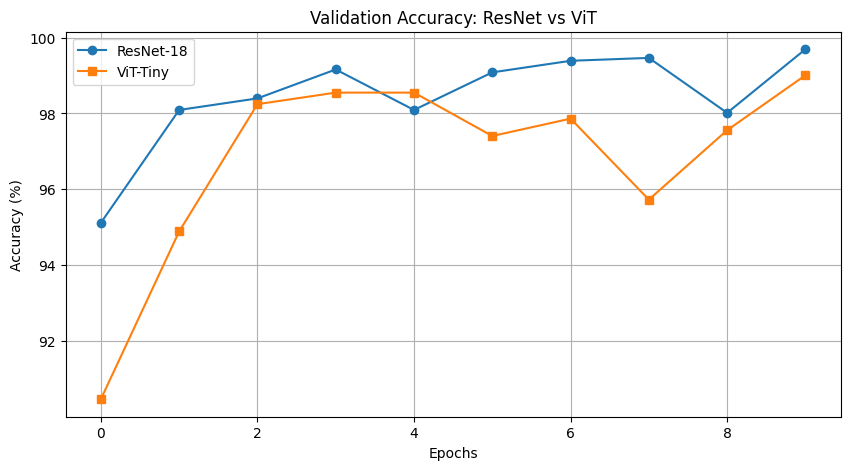

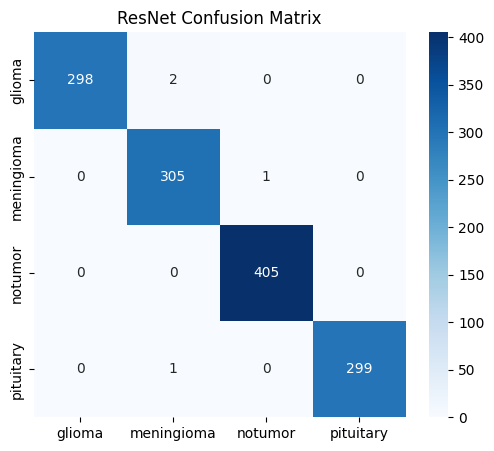

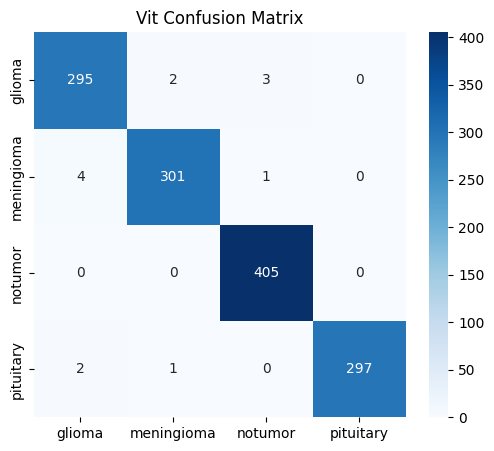

In [10]:
# 准确率对比
plt.figure(figsize=(10, 5))
plt.plot(resnet_hist['val_acc'], label='ResNet-18', marker='o')
plt.plot(vit_hist['val_acc'], label='ViT-Tiny', marker='s')
plt.title("Validation Accuracy: ResNet vs ViT")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

# 混淆矩阵
def plot_cm(model, title):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title(title)
    plt.show()

plot_cm(resnet_model, "ResNet Confusion Matrix")
plot_cm(vit_model, "Vit Confusion Matrix")

Grad-CAM 

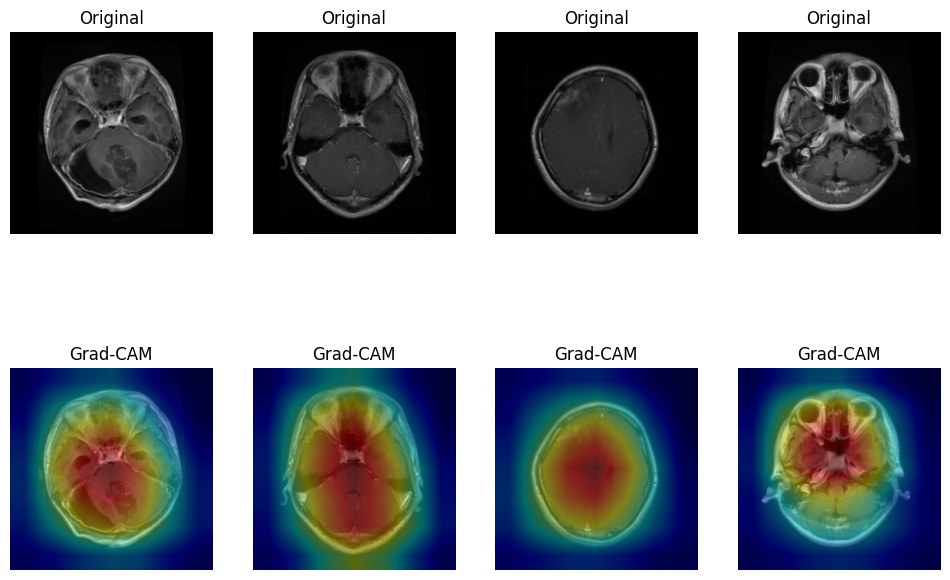

In [11]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)
        if class_idx is None: class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[0, class_idx].backward()
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights): cam += w * activations[i]
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

# 运行 Grad-CAM
target_layer = resnet_model.layer4[-1]
grad_cam = GradCAM(resnet_model, target_layer)
data_iter = iter(test_loader)
images, labels = next(data_iter)

plt.figure(figsize=(12, 8))
for i in range(4):
    img_tensor = images[i].unsqueeze(0).to(DEVICE)
    heatmap = grad_cam(img_tensor)
    img_np = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    superimposed = heatmap_colored * 0.4 + img_np * 0.6
    
    plt.subplot(2, 4, i+1)
    plt.imshow(img_np); plt.title("Original"); plt.axis('off')
    plt.subplot(2, 4, i+5)
    plt.imshow(superimposed); plt.title("Grad-CAM"); plt.axis('off')
plt.show()

In [12]:
import pandas as pd

# 获取 ResNet 的预测
resnet_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = resnet_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 生成报告并转为 DataFrame 显示
report_dict = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
print(df_report)
# 把这个表格截图或者复制到 Markdown 报告里！

              precision    recall  f1-score      support
glioma         1.000000  0.993333  0.996656   300.000000
meningioma     0.990260  0.996732  0.993485   306.000000
notumor        0.997537  1.000000  0.998767   405.000000
pituitary      1.000000  0.996667  0.998331   300.000000
accuracy       0.996949  0.996949  0.996949     0.996949
macro avg      0.996949  0.996683  0.996810  1311.000000
weighted avg   0.996966  0.996949  0.996951  1311.000000


In [13]:
# 获取vit
vit_model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        outputs = vit_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 生成报告并转为 DataFrame 显示
report_dict = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
print(df_report)
# 把这个表格截图或者复制到 Markdown 报告里！

              precision    recall  f1-score      support
glioma         0.980066  0.983333  0.981697   300.000000
meningioma     0.990132  0.983660  0.986885   306.000000
notumor        0.990220  1.000000  0.995086   405.000000
pituitary      1.000000  0.990000  0.994975   300.000000
accuracy       0.990084  0.990084  0.990084     0.990084
macro avg      0.990105  0.989248  0.989661  1311.000000
weighted avg   0.990114  0.990084  0.990083  1311.000000


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_inference_time(model, sample_input):
    model.eval()
    # 预热
    for _ in range(10): _ = model(sample_input)
    
    start = time.time()
    for _ in range(10000): # 测10000次
        with torch.no_grad():
            _ = model(sample_input)
    end = time.time()
    return (end - start) / 10000 * 1000 # 毫秒

dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)
res_params = count_parameters(resnet_model)
vit_params = count_parameters(vit_model)
res_time = measure_inference_time(resnet_model, dummy_input)
vit_time = measure_inference_time(vit_model, dummy_input)

print(f"ResNet Parameters: {res_params/1e6:.2f}M, Inference Time: {res_time:.2f}ms")
print(f"ViT Parameters: {vit_params/1e6:.2f}M, Inference Time: {vit_time:.2f}ms")

ResNet Parameters: 11.18M, Inference Time: 1.95ms
ViT Parameters: 5.53M, Inference Time: 4.50ms


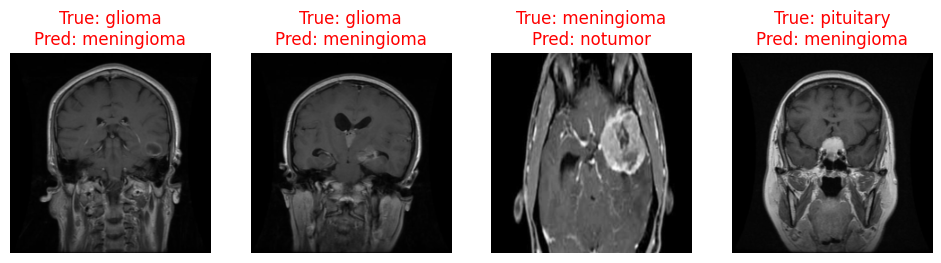

In [15]:
# 找出分错的图
wrong_images = []
wrong_labels = []
wrong_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = resnet_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # 找错误的索引
        mismatches = (preds != labels)
        if mismatches.any():
            wrong_images.extend(inputs[mismatches].cpu())
            wrong_labels.extend(labels[mismatches].cpu())
            wrong_preds.extend(preds[mismatches].cpu())
            if len(wrong_images) > 5: break # 找够5张就行

# 画出来
plt.figure(figsize=(15, 5))
for i in range(len(wrong_images)):
    if i >= 5: break
    img = wrong_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {CLASSES[wrong_labels[i]]}\nPred: {CLASSES[wrong_preds[i]]}", color='red')
    plt.axis('off')
plt.show()

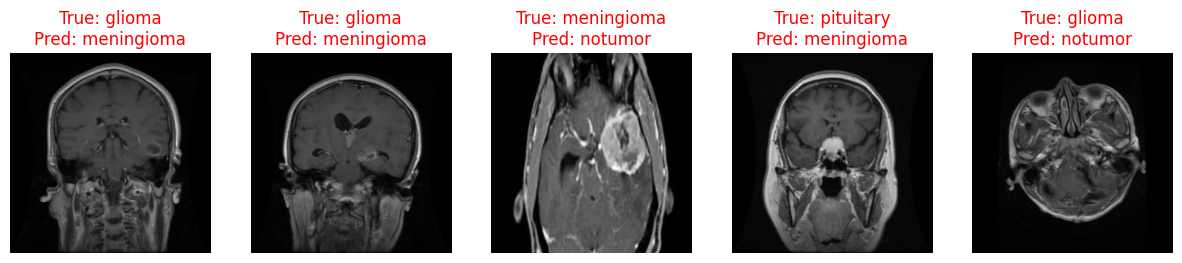

In [16]:
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = vit_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        # 找错误的索引
        mismatches = (preds != labels)
        if mismatches.any():
            wrong_images.extend(inputs[mismatches].cpu())
            wrong_labels.extend(labels[mismatches].cpu())
            wrong_preds.extend(preds[mismatches].cpu())
            if len(wrong_images) > 5: break # 找够5张就行

# 画出来
plt.figure(figsize=(15, 5))
for i in range(len(wrong_images)):
    if i >= 5: break
    img = wrong_images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: {CLASSES[wrong_labels[i]]}\nPred: {CLASSES[wrong_preds[i]]}", color='red')
    plt.axis('off')
plt.show()